### 사용 서버 및 사용량

In [1]:
import os
import tensorflow.compat.v1 as tf1

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
session = tf1.Session(config=config)

2024-09-01 05:25:07.476867: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-01 05:25:07.783158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 05:25:10.009551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-01 05:25:12.971804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capabi

### 이미지 불러오기

In [2]:
import os
import numpy as np

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 각 경로에서 이미지 파일을 가져와 변수에 저장
path_Mild_Demented = "/home/b202192017/2024.05.29_전주대_학부생_4학년1학기_백업파일/2024/논문/new_idea_code/image/Mild_Demented_train/"
path_Non_Demented = "/home/b202192017/2024.05.29_전주대_학부생_4학년1학기_백업파일/2024/논문/new_idea_code/image/Non_Demented_train/"

images_Mild_Demented = read_images_from_path(path_Mild_Demented)
images_Non_Demented = read_images_from_path(path_Non_Demented)

# 변수에 저장된 이미지 수 출력
print(f"Number of images in Mild_Demented: {len(images_Mild_Demented)}")
print(f"Number of images in Non_Demented: {len(images_Non_Demented)}")

Number of images in Mild_Demented: 627
Number of images in Non_Demented: 2240


In [3]:
print(np.shape(images_Mild_Demented[0]))

()


### 이미지 시각화

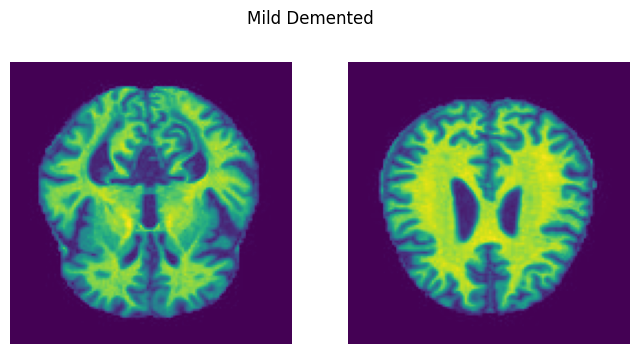

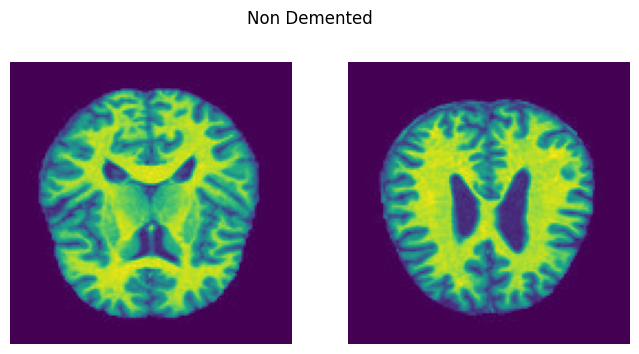

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def read_images_from_path(path, num_images=2):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")][:num_images]
    images = [os.path.join(path, f) for f in image_files]
    return images

def plot_images(images, title):
    plt.figure(figsize=(8, 4))
    for i, image_path in enumerate(images, 1):
        plt.subplot(1, len(images), i)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 각 경로에서 2장씩 이미지를 읽어와서 그림
images_Mild_Demented = read_images_from_path(path_Mild_Demented, num_images=2)
plot_images(images_Mild_Demented, title="Mild Demented")


images_Non_Demented = read_images_from_path(path_Non_Demented, num_images=2)
plot_images(images_Non_Demented, title="Non Demented")



### 이미지 넘파이 배열로 변환

In [19]:
import os
import matplotlib.image as mpimg
import numpy as np

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 각 경로에서 모든 이미지를 읽어와서 numpy 배열로 변환
images_Mild_Demented = read_images_from_path(path_Mild_Demented) # 몇개, 가로, 세로
numpy_array_Mild_Demented = images_to_numpy(images_Mild_Demented)# 몇개, 가로, 세로


images_Non_Demented = read_images_from_path(path_Non_Demented)
numpy_array_Non_Demented = images_to_numpy(images_Non_Demented)


# 넘파이 배열의 크기 확인
print("Mild Demented Shape:", numpy_array_Mild_Demented.shape)
print("Non Demented Shape:", numpy_array_Non_Demented.shape)

Mild Demented Shape: (627, 128, 128)
Non Demented Shape: (2240, 128, 128)


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import Callback
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from sklearn import mixture
from sklearn.cluster import KMeans
import math
import scipy
import time

### 원하는 군집 이미지 선택

In [21]:
# 정상 = numpy_array_Non_Demented
# 경증 = numpy_array_Mild_Demented

choose_cluster = numpy_array_Non_Demented

### 모델 학습 핵심 하이퍼파라미터 선택

In [22]:
epochs = 1000
batch_size = 32

### 생성할 이미지의 갯수 정하기

In [23]:
# 숫자
# 정상의 배수 = images_Non_Demented * ...
# 경증의 배수 = images_Mild_Demented * ...

make_image = (len(images_Non_Demented) * 2)

batch_size_images = 100 # 한번에 생성할 갯수 -> 100개씩 생성해라.


### VAE 이미지 학습

In [24]:
X_data = np.reshape(choose_cluster, (-1,128,128,1))

In [25]:
print(np.max(X_data), np.min(X_data))

255 0


In [26]:
X_data = X_data / 255.
print(np.max(X_data), np.min(X_data))

1.0 0.0


In [27]:
X_data = np.reshape(X_data, (-1,128*128))
print(np.shape(X_data))

(2240, 16384)


In [28]:
latent_dim = 256

# 인코더 모델 정의
encoder_inputs = keras.Input(shape=(128*128,))
x = layers.Dense(500, activation="relu")(encoder_inputs)
x = layers.Dense(500, activation="relu")(x)
x = layers.Dense(2000, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# 디코더 모델 정의
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(2000, activation="relu")(latent_inputs)
x = layers.Dense(500, activation="relu")(x)
x = layers.Dense(500, activation="relu")(x)
decoder_outputs = layers.Dense(128*128, activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [30]:
# VAE 모델 정의
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling((z_mean, z_log_var))
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= (128*128)
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        return self.decoder(z)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# 모델 인스턴스 생성
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))
st = time.time()
vae.fit(X_data, epochs=epochs, batch_size=batch_size)
et = time.time() - st
print("총 걸린 시간 : ", et)

Epoch 1/1000
70/70 [==============================] - 6s 9ms/step - loss: 6499.1682 - reconstruction_loss: 6489.3657 - kl_loss: 9.8025
Epoch 2/1000
70/70 [==============================] - 1s 9ms/step - loss: 5381.3259 - reconstruction_loss: 5375.1924 - kl_loss: 6.1335
Epoch 3/1000
70/70 [==============================] - 1s 9ms/step - loss: 5271.2390 - reconstruction_loss: 5265.6313 - kl_loss: 5.6077
Epoch 4/1000
70/70 [==============================] - 1s 9ms/step - loss: 5195.4077 - reconstruction_loss: 5191.0920 - kl_loss: 4.3158
Epoch 5/1000
70/70 [==============================] - 1s 9ms/step - loss: 5153.1086 - reconstruction_loss: 5149.3542 - kl_loss: 3.7544
Epoch 6/1000
70/70 [==============================] - 1s 9ms/step - loss: 5135.4669 - reconstruction_loss: 5132.2913 - kl_loss: 3.1755
Epoch 7/1000
70/70 [==============================] - 1s 9ms/step - loss: 5115.7268 - reconstruction_loss: 5112.8526 - kl_loss: 2.8743
Epoch 8/1000
70/70 [==============================] - 1

70/70 [==============================] - 1s 10ms/step - loss: 4953.3798 - reconstruction_loss: 4951.5373 - kl_loss: 1.8425
Epoch 62/1000
70/70 [==============================] - 1s 9ms/step - loss: 4950.2964 - reconstruction_loss: 4948.4152 - kl_loss: 1.8812
Epoch 63/1000
70/70 [==============================] - 1s 9ms/step - loss: 4948.4591 - reconstruction_loss: 4946.5638 - kl_loss: 1.8953
Epoch 64/1000
70/70 [==============================] - 1s 9ms/step - loss: 4947.4383 - reconstruction_loss: 4945.5593 - kl_loss: 1.8790
Epoch 65/1000
70/70 [==============================] - 1s 9ms/step - loss: 4946.8420 - reconstruction_loss: 4944.9487 - kl_loss: 1.8933
Epoch 66/1000
70/70 [==============================] - 1s 9ms/step - loss: 4944.9818 - reconstruction_loss: 4943.0848 - kl_loss: 1.8969
Epoch 67/1000
70/70 [==============================] - 1s 9ms/step - loss: 4941.7597 - reconstruction_loss: 4939.8469 - kl_loss: 1.9128
Epoch 68/1000
70/70 [==============================] - 1s 9ms

KeyboardInterrupt: 

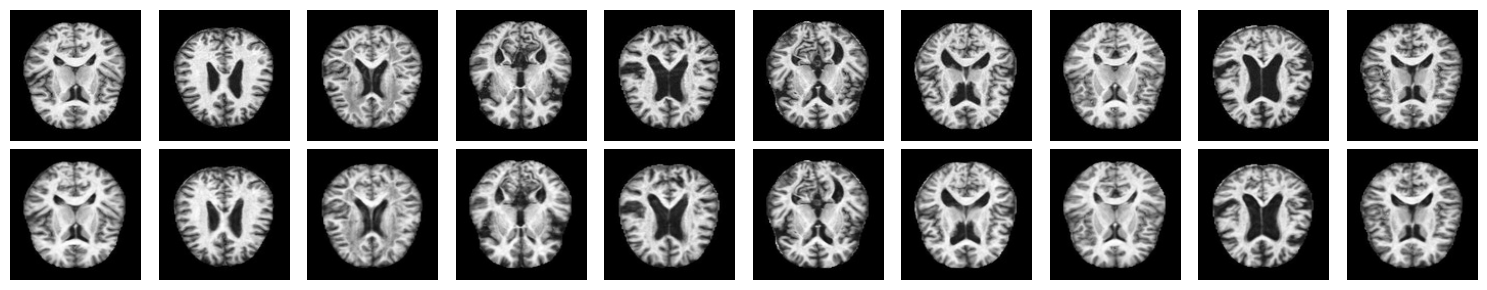

In [16]:
# Get the z_mean and generate reconstructions
z, z_log_var= vae.encoder(X_data[:10])
reconstruction = vae.decoder(z)

# Reshape the images to match the plot layout
original_images = X_data[:10].reshape(10, 128, 128)
reconstructed_images = reconstruction.numpy().reshape(10, 128, 128)

# Create a plot with 2 rows and 10 columns
fig, axs = plt.subplots(2, 10, figsize=(15, 3))

# Plot the original images in the first row
for i in range(10):
    axs[0, i].imshow(original_images[i], cmap='gray')
    axs[0, i].axis('off')

# Plot the reconstructed images in the second row
for i in range(10):
    axs[1, i].imshow(reconstructed_images[i], cmap='gray')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

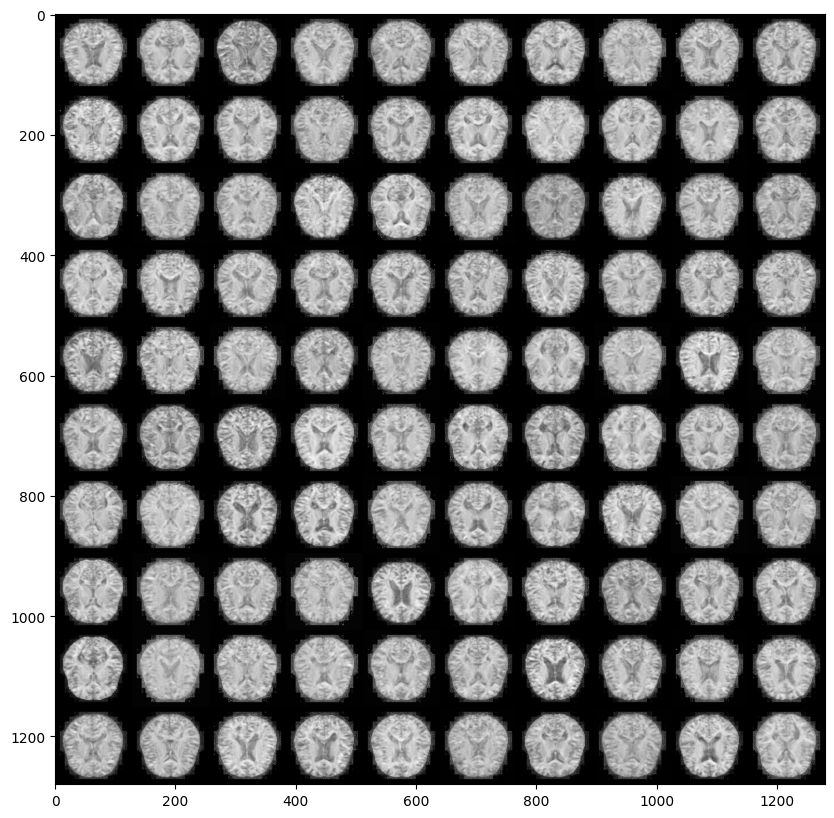

In [17]:
n = 10
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))
z_sample = np.random.randn(100, 256)

for i, yi in enumerate(range(10)):
    for j, xi in enumerate(range(10)):
        digit_idx = i * n + j
        digit = vae.decoder.predict(z_sample[digit_idx].reshape(1, -1), verbose=0)
        digit = digit.reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()

### VAE 이미지 생성 저장

In [15]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img

# 이미지를 저장할 디렉토리 경로 설정
save_dir = "/home/b202192017/2024.05.29_전주대_학부생_4학년1학기_백업파일/2024/논문/new_idea_code/new_image/VAE_Non_e1000_random-vector_1"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 잠재 공간의 차원 확인
latent_dim = 256  # AE_encoder 모델의 출력 차원에 따라 조정

# 이미지 생성 및 저장을 위한 배치 처리
batch_size_images = batch_size_images  # 한 번에 처리할 이미지 수
make_image = make_image  # 총 생성할 이미지 수

# 잠재 공간에서 무작위 벡터 생성
for i in range(0, n_images, batch_size):
    # 배치 크기만큼 무작위 잠재 벡터 생성
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 디코더를 사용하여 배치 이미지 생성
    generated_images = vae.decoder.predict(random_latent_vectors)

    for j, generated_image in enumerate(generated_images):
        # 생성된 이미지를 128x128 크기로 변환
        generated_image = generated_image.reshape((128, 128, 1))

        # 이미지 배열을 이미지로 변환
        img = array_to_img(generated_image * 255.0, scale=False)

        # 이미지 파일 저장
        img.save(os.path.join(save_dir, f"generated_image_{i+j+1}.jpg"))

    # 진행 상태 메시지 출력
    print(f"{i+batch_size if i+batch_size < n_images else n_images}개의 이미지 생성 및 저장 완료.")

print(f"총 {n_images}개의 이미지 생성 및 저장 완료.")


4/4 [==============================] - 0s 6ms/step
100개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 7ms/step
200개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 7ms/step
300개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 8ms/step
400개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 10ms/step
500개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 5ms/step
600개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 5ms/step
700개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 10ms/step
800개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 6ms/step
900개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 4ms/step
1000개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 5ms/step
1100개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 4ms/step
1200개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 13ms/step
1254개의 이미지 생성 및 저장 완료.
총 1254개의 이미지 생성 및 저장 완료.


In [18]:
# # 파일 복사 코드 -> 파일 관리 작업

# import os
# import shutil

# # 소스 디렉토리 경로
# source_dirs = [
#     "MRI_치매_데이터__/Mild_Demented_train/",
#     "MRI_치매_데이터__생성_new/VAE_Mild_e1000_random-vector_5"
# ]

# # 대상 디렉토리 경로
# target_dir = "MRI_치매_데이터생성/Mild_train+VAE_Mild_e1000_random-vector_5"

# # 대상 디렉토리 생성
# if not os.path.exists(target_dir):
#     os.makedirs(target_dir)

# # 각 소스 디렉토리에서 파일을 대상 디렉토리로 복사
# for source_dir in source_dirs:
#     for filename in os.listdir(source_dir):
#         source_path = os.path.join(source_dir, filename)
        
#         # 파일이 아닌 경우(디렉토리 등)는 건너뛰기
#         if not os.path.isfile(source_path):
#             print(f"디렉토리 또는 파일이 아닌 항목을 건너뜁니다: {source_path}")
#             continue
        
#         # 동일한 파일 이름이 있는 경우를 대비하여 파일 이름 변경
#         target_path = os.path.join(target_dir, filename)
#         if os.path.isfile(target_path):
#             base, extension = os.path.splitext(filename)
#             count = 1
#             new_filename = f"{base}_{count}{extension}"
#             new_target_path = os.path.join(target_dir, new_filename)
#             while os.path.isfile(new_target_path):
#                 count += 1
#                 new_filename = f"{base}_{count}{extension}"
#                 new_target_path = os.path.join(target_dir, new_filename)
#             target_path = new_target_path
        
#         # 파일 복사
#         shutil.copy(source_path, target_path)

# print("파일 복사 완료")
